# Marketing HW 3

#### *Apolline, Fatma, Ulysse*

## Assignment 3: Base pricing analysis for detergent category

We start by importing all modules that we will need, and we ensure that the CSV works properly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
df = pd.read_csv("./Detergent.csv")

In [3]:
df.head()

,Unnamed: 0,store,week,acv,promoflag,q_tide128,p_tide128,q_tide64,p_tide64,q_wisk64,p_wisk64
0,1,2,1,13828.87,1,34,8.701765,26,5.111538,71,3.29
1,2,2,2,13828.87,0,46,8.670435,42,5.020476,16,4.19
2,3,2,3,13828.87,0,43,8.720233,48,5.049375,35,4.19
3,4,2,4,13828.87,0,165,8.738484,33,5.056667,26,4.19
4,5,2,5,13828.87,1,77,6.990000,35,5.116857,33,4.19


**We know that:**
* We are working with P&G, specifically their flagship laundry detergent brand, Tide.
* We want to construct a base pricing analysis for Tide

**Also, there are 3 main questions to be answered:**
1) What is the extent of cannibalization within the Tide product line?
2) Does Tide face a competitive threat from Wisk?
3) How do you evaluate the current pricing tactics? Do you recommend changes?

*Information to remember:*
- 86 stores
- 3 kinds of products:
  - Tide 128 oz
  - Tide 64 oz
  - Wisk 64 oz
- Data generally available for up 300 weeks

**Variable names and what they correspond to:**
* Store: Store id number
* Week: Week
* Acv: ACV (all commodity volume), in $1,000
* promoflag = 1: if any product in the category was on promotion
* q_tide128: Tide 128 oz unit sales
* p_tide128: Tide 128 oz price ($)
* q_tide64: Tide 64 oz unit sales
* p_tide64: Tide 64 oz price ($)
* q_wisk64: Wisk 64 oz unit sales
* p_wisk64: Wisk 64 oz price ($)

## **Question 1: Data description**

### a) Report the revenue market shares of the three products (percentage of total sales revenue across all store-weeks), and report the mean, median, and standard deviation of prices for the three products across store-weeks. Make a table of these variables. (0.5 points)

Based on the variable names, looking at the df.head() from above, we can see that the index has also been imported, so we make sure to remove the first unnamed column to get rid of any potential errors

In [4]:
df.drop(columns="Unnamed: 0", inplace=True)
df.head()

,store,week,acv,promoflag,q_tide128,p_tide128,q_tide64,p_tide64,q_wisk64,p_wisk64
0,2,1,13828.87,1,34,8.701765,26,5.111538,71,3.29
1,2,2,13828.87,0,46,8.670435,42,5.020476,16,4.19
2,2,3,13828.87,0,43,8.720233,48,5.049375,35,4.19
3,2,4,13828.87,0,165,8.738484,33,5.056667,26,4.19
4,2,5,13828.87,1,77,6.990000,35,5.116857,33,4.19


In [5]:
#we first calculate the revenue for each product for every week and every store
df['revenue_tide128'] = df['q_tide128'] * df['p_tide128'] #this adds a new column in our df, called revenue_tide128
df['revenue_tide64'] = df['q_tide64'] * df['p_tide64']
df['revenue_wisk64'] = df['q_wisk64'] * df['p_wisk64']

#then, we find the total revenue per product
total_revenue_tide128 = df['revenue_tide128'].sum() #this returns a single number, not a column
total_revenue_tide64 = df['revenue_tide64'].sum()
total_revenue_wisk64 = df['revenue_wisk64'].sum()
total_revenue = total_revenue_tide128 + total_revenue_tide64 + total_revenue_wisk64

print(f"The total revenue (rounded to two decimals) is ${round(total_revenue,2)}")

The total revenue (rounded to two decimals) is $16574971.11


From this, we go on to find the market share:

In [6]:
market_share_tide128 = (total_revenue_tide128 / total_revenue) * 100
market_share_tide64 = (total_revenue_tide64 / total_revenue) * 100
market_share_wisk64 = (total_revenue_wisk64 / total_revenue) * 100

Now for the statistics:

In [7]:
#we write those in a dictionary to make it easier to navigate and transform in a df later
price_stats = {
    "Product": ["Tide 128 oz", "Tide 64 oz", "Wisk 64 oz"],
    "Mean Price": [
        df['p_tide128'].mean(),
        df['p_tide64'].mean(),
        df['p_wisk64'].mean()
    ],
    "Median Price": [
        df['p_tide128'].median(),
        df['p_tide64'].median(),
        df['p_wisk64'].median()
    ],
    "Std Dev Price": [
        df['p_tide128'].std(),
        df['p_tide64'].std(),
        df['p_wisk64'].std()
    ]
}

#and now we make a dataframe out of the statistics and the market share:

summary_table = pd.DataFrame(price_stats)
market_shares = {
    "Product": ["Tide 128 oz", "Tide 64 oz", "Wisk 64 oz"],
    "Market Share (%)": [
        market_share_tide128,
        market_share_tide64,
        market_share_wisk64
    ]
}
market_share_table = pd.DataFrame(market_shares)

#finally, we merge both tables based on the "Product" variable, allowing all of the information to be in a single table
combined_table = pd.merge(summary_table, market_share_table, on="Product")
combined_table

,Product,Mean Price,Median Price,Std Dev Price,Market Share (%)
0,Tide 128 oz,8.363219,8.476207,0.760049,56.856988
1,Tide 64 oz,4.375451,4.419412,0.404608,26.336469
2,Wisk 64 oz,4.071963,4.190000,0.490453,16.806543


### b) Then generate two new variables that capture the price gap (price difference) between;

### (i) Tide 128oz and Tide 64oz

### (ii) Tide 64oz and Wisk 64oz

### Report the mean, median, and standard deviation of the two price gap variables across store-weeks. Make a table showing these statistics. (0.5 points)

Assuming that we do not take the absolute value price difference but rather the basic *price(Tide 128oz) - price(Tide 64oz)* price difference, which allows for negative numbers;

In [8]:
#first one
df['pd_tide128_tide64'] = df['p_tide128'] - df['p_tide64']
#second one
df['pd_tide64_wisk4'] = df['p_tide64'] - df['p_wisk64']
#note: pd stands for price difference, and we put the variables in the same order as the subtraction

df.head()

,store,week,acv,promoflag,q_tide128,p_tide128,q_tide64,p_tide64,q_wisk64,p_wisk64,revenue_tide128,revenue_tide64,revenue_wisk64,pd_tide128_tide64,pd_tide64_wisk4
0,2,1,13828.87,1,34,8.701765,26,5.111538,71,3.29,295.860010,132.899988,233.59,3.590227,1.821538
1,2,2,13828.87,0,46,8.670435,42,5.020476,16,4.19,398.840010,210.859992,67.04,3.649959,0.830476
2,2,3,13828.87,0,43,8.720233,48,5.049375,35,4.19,374.970019,242.370000,146.65,3.670858,0.859375
3,2,4,13828.87,0,165,8.738484,33,5.056667,26,4.19,1441.849860,166.870011,108.94,3.681817,0.866667
4,2,5,13828.87,1,77,6.990000,35,5.116857,33,4.19,538.230000,179.089995,138.27,1.873143,0.926857


And now for the statistics:

In [9]:
pd_stats = {
    "Price difference": ["pd_tide128_tide64", "pd_tide64_wisk4"],
    "Mean Price Difference": [
        df['pd_tide128_tide64'].mean(),
        df['pd_tide64_wisk4'].mean()
    ],
    "Median Price Difference": [
        df['pd_tide128_tide64'].median(),
        df['pd_tide64_wisk4'].median()
    ],
    "Std Dev Price Difference": [
        df['pd_tide128_tide64'].std(),
        df['pd_tide64_wisk4'].std()
    ]
}
pd_summary_table = pd.DataFrame(pd_stats)

pd_summary_table

,Price difference,Mean Price Difference,Median Price Difference,Std Dev Price Difference
0,pd_tide128_tide64,3.987768,4.094000,0.870574
1,pd_tide64_wisk4,0.303489,0.260714,0.585964


### c) Provide histograms of the price gaps. (0.5 points)

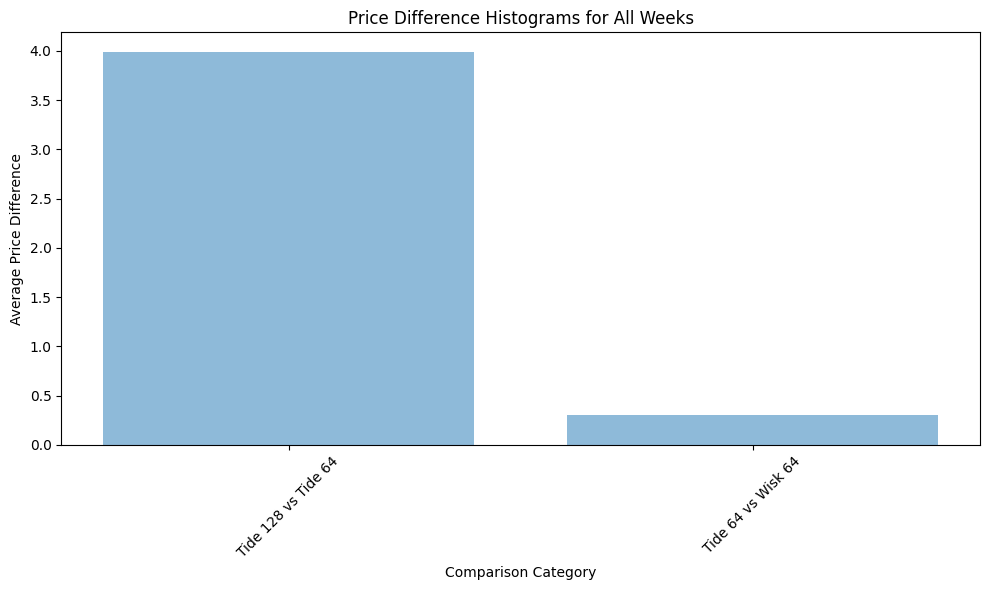

In [ ]:
def plot_histograms(df=None, average_df=None, average_histo="no", all_weeks="yes", 
                    week_nb=0, group_by_week="no", group_by_store="no", all_stores="yes", store_nb=0,
                    bins=15, alpha=0.5):
    if average_histo == "no":
        required_columns = ['week', 'store', 'pd_tide128_tide64', 'pd_tide64_wisk4']
        if df is None or not all(col in df.columns for col in required_columns):
            raise ValueError("Dataframe `df` is missing required columns or not provided.")
    if average_histo == "yes" and average_df is None:
        raise ValueError("`average_df` is required for plotting average histograms.")
    if all_weeks == "no" and week_nb <= 0:
        raise ValueError("`week_nb` must be a positive integer when `all_weeks` is 'no'.")
    if group_by_week == "yes" and group_by_store == "yes":
        raise ValueError("Cannot group by both week and store simultaneously.")
    if all_stores == "no" and store_nb <= 0:
        raise ValueError("`store_nb` must be a positive integer when `all_stores` is 'no'.")

        """    
        def plot_single_histogram(data, title, labels):
        #Plots histograms from a dataframe with column-based data.
        if data is None or data.empty:
            raise ValueError(f"No data available for plotting: {title}")
        
        plt.figure(figsize=(10, 6))
        for label, col in labels.items():
            if col in data.columns:  # Check if the column exists in the dataframe
                plt.hist(data[col], bins=bins, alpha=alpha, label=label)
        plt.title(title)
        plt.xlabel('Price Difference')
        plt.ylabel('Frequency (How many weeks this has happened)')
        plt.legend()
        plt.show()

#or

    def plot_single_histogram(data, title, labels):
        #Plots bar charts from a dataframe with column-based data
        if data is None or data.empty:
            raise ValueError(f"No data available for plotting: {title}")
        
        plt.figure(figsize=(10, 6))
        x_labels = list(labels.keys())
        bar_width = 0.35
        
        # Collect averages for each column
        averages = [data[col].mean() for col in labels.values() if col in data.columns]

        # Bar chart
        x = range(len(x_labels))
        plt.bar(x, averages, alpha=alpha)

        # Add labels and titles
        plt.xticks(x, x_labels, rotation=45)
        plt.title(title)
        plt.ylabel('Average Price Difference')
        plt.xlabel('Comparison Category')
        plt.tight_layout()
        plt.show()
        """

    def plot_single_summary_histogram(summary_df, title):
        """Plots bar charts from the summary dataframe where rows represent data."""
        if summary_df is None or summary_df.empty:
            raise ValueError(f"No data available for plotting: {title}")

        plt.figure(figsize=(10, 6))
        
        # Iterate over rows in the summary table to create a bar chart
        x_labels = []
        mean_values = []
        median_values = []
        
        for _, row in summary_df.iterrows():
            x_labels.append(row['Price difference'])
            mean_values.append(row['Mean Price Difference'])
            median_values.append(row['Median Price Difference'])

        # Create bar width
        bar_width = 0.35
        x = range(len(x_labels))  # x positions for the bars

        # Bar chart for mean and median
        plt.bar(x, mean_values, width=bar_width, alpha=alpha, label="Mean Price Difference")
        plt.bar([pos + bar_width for pos in x], median_values, width=bar_width, alpha=alpha, label="Median Price Difference")

        # Add labels, titles, and legend
        plt.xticks([pos + bar_width / 2 for pos in x], x_labels, rotation=45)
        plt.title(title)
        plt.ylabel('Price Difference')
        plt.xlabel('Price Difference Category')
        plt.legend()
        plt.tight_layout()
        plt.show()


    # Main logic
    if df is not None:  # Only process df-related logic if df is provided
        if all_stores == "no" and store_nb > 0:
            subset = df[df['store'] == store_nb]
            if all_weeks == "yes" and not subset.empty:
                plot_single_histogram(subset, f'Price Difference Histograms for Store {store_nb} (All Weeks)',
                                      {'Tide 128 vs Tide 64': 'pd_tide128_tide64',
                                       'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})
            elif week_nb > 0 and not subset.empty:
                subset = subset[subset['week'] == week_nb]
                plot_single_histogram(subset, f'Price Difference Histograms for Store {store_nb}, Week {week_nb}',
                                      {'Tide 128 vs Tide 64': 'pd_tide128_tide64',
                                       'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})

        if group_by_week == "yes":
            for week in df['week'].unique():
                subset = df[df['week'] == week]
                plot_single_histogram(subset, f'Price Difference Histograms for Week {week}', 
                                      {'Tide 128 vs Tide 64': 'pd_tide128_tide64', 
                                       'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})

        if group_by_store == "yes" and all_weeks == "yes":
            for store in df['store'].unique():
                subset = df[df['store'] == store]
                plot_single_histogram(subset, f'Price Difference Histograms for Store {store} (All Weeks)', 
                                      {'Tide 128 vs Tide 64': 'pd_tide128_tide64', 
                                       'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})

        if group_by_store == "no" and all_weeks == "yes":
            plot_single_histogram(df, 'Price Difference Histograms for All Weeks', 
                                  {'Tide 128 vs Tide 64': 'pd_tide128_tide64', 
                                   'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})

        if all_weeks == "no" and week_nb > 0:
            subset = df[df['week'] == week_nb]
            plot_single_histogram(subset, f'Price Difference Histograms for Week {week_nb}', 
                                  {'Tide 128 vs Tide 64': 'pd_tide128_tide64', 
                                   'Tide 64 vs Wisk 64': 'pd_tide64_wisk4'})

    if average_histo == "yes":  # Use summary histogram logic
        plot_single_summary_histogram(average_df, 'Average Price Difference Histogram')

#we do a histogram with the basic options (all weeks, original dataframe, no grouping by either the week or the store)


#plot_histograms(df=df)

And now the histogram for the averages, which is likely what we care about the most

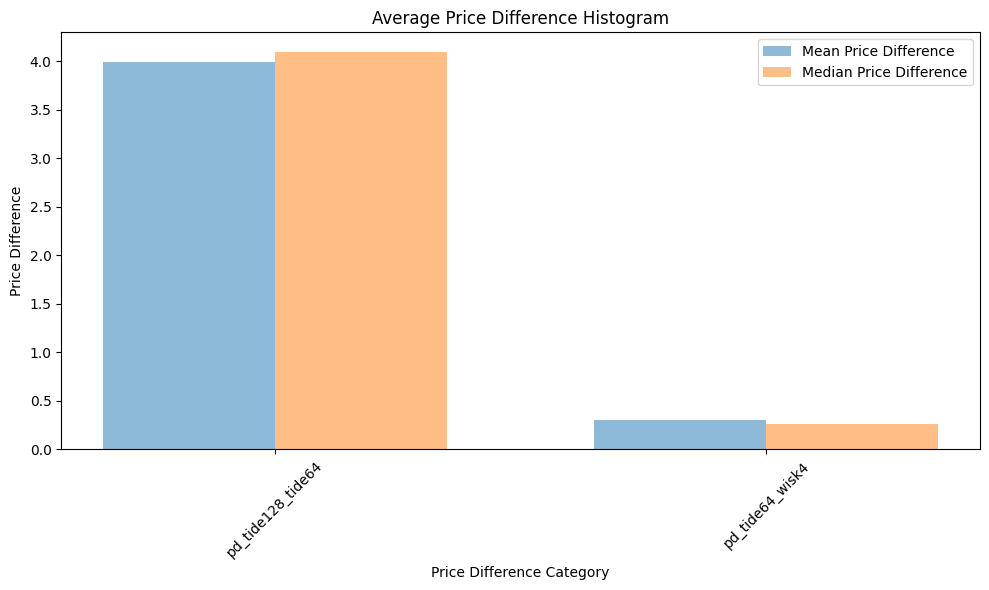

In [17]:
plot_histograms(average_df=pd_summary_table,average_histo='yes')

### d) What do you learn from the price gap histograms and summary statistics for your analysis above? Is there enough variation in the price gaps across stores and weeks to estimate the cross-price elasticities between the two Tide pack sizes and Wisk 64? (0.5 points)
